This notebook contains experimental code used for covid data cleansing and plots, from before i moved code into covid_app.py.
Kept for reference but not used now

Ideas
- add population data per country
- NOTE: lat/long were added to daily data on march 1st: jan and feb tables only have province/country!

#XXX NEXT STEPS
- SLIDER TO SELECT DATES
- TOGGLE TO SELECT MEASURE
- shading by counts - how to scale colourbar?

- add second tab for global totals by date


- 

# Imports and functions

In [31]:
import logging
import glob
import pandas as pd
import os
import geopandas as gpd
import json 
import datetime
import itertools
from bokeh.io import output_notebook, show, output_file, curdoc
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.models import DateSlider, Select, HoverTool, DatetimeTickFormatter, NumeralTickFormatter
from bokeh.layouts import widgetbox, row, column
from bokeh.models.annotations import Title
from bokeh.models.widgets import Panel, Tabs
import colorcet 

In [2]:
def prepare_data(df, metric):
    
    # organise cols
    
    df.rename({'Country/Region': 'country', 'Province/State': 'province'}, axis=1, inplace=True)
    df.columns = [x.lower() for x in df.columns]
    df.fillna('No data', inplace=True)
    
    # convert from wide to long 
    # to get one row per province/country/date

    df = pd.melt(df, id_vars=['country', 'province', 'lat', 'long'],
                 var_name='day', value_name=metric)

    df.set_index(['country', 'province', 'lat', 'long', 'day'], inplace=True)
    
    return df.sort_values(by=['country', 'province'])



# def prepare_geojsondata(df):
#     """used in plot 1 only, not in app so commented out"""
#     ## Convert GeoDataFrame to GeoJSON format so it can be read by Bokeh 
#     # (Bokeh consumes GeoJSON format which represents geographical features with JSON)

#     # Read data to json.
#     df_json = json.loads(df.to_json())

#     # Convert to String like object.
#     json_data = json.dumps(df_json)
    
#     # Convert JSON to GeoDataSource to be read by Bokeh
#     geosource = GeoJSONDataSource(geojson=json_data)
    
#     return geosource

# Data: COVID cases

## Time series - USE
- one file per measure (confirmed dealths, recovered)
- one row per province/country
- no duplicates from latlongs or multiple entries in same day
    - however, latlongs have dodgy numbers of digits so not very accurate: prob wont use these!
- dates are columns, with new col added each day and zeros for missing data

In [3]:
os.chdir('/Users/jdorni/Documents/training/covid-19-bokeh/data/csse_covid_19_data/csse_covid_19_time_series')

confirmed = pd.read_csv('time_series_covid19_confirmed_global.csv')
deaths = pd.read_csv('time_series_covid19_deaths_global.csv')
recovered = pd.read_csv('time_series_covid19_recovered_global.csv')

In [4]:
confirmed_melted = prepare_data(df=confirmed, metric='confirmed')
deaths_melted = prepare_data(df=deaths, metric='deaths')
recovered_melted = prepare_data(df=recovered, metric='recovered')

In [5]:
print(len(confirmed), len(confirmed_melted))
print(len(deaths), len(deaths_melted))
print(len(recovered), len(recovered_melted))

264 24552
264 24552
250 23250


In [6]:
df = pd.concat([confirmed_melted, deaths_melted, recovered_melted], axis=1)
df.reset_index(inplace=True)


# sum provinces to get totals by whole countries  

df = df.groupby(['country', 'day']).agg(
    confirmed=pd.NamedAgg(column='confirmed', aggfunc='sum'),
    deaths=pd.NamedAgg(column='deaths', aggfunc='sum'),
    recovered=pd.NamedAgg(column='recovered', aggfunc='sum'))

df = df.reset_index()

# convert date to a sortable string format
df['day'] = pd.to_datetime(df['day']).dt.strftime("%Y-%m-%d")
#df['day'] = pd.to_datetime(df['day']).dt.date

df.head()

,country,day,confirmed,deaths,recovered
0,Afghanistan,2020-01-22,0.0,0.0,0.0
1,Afghanistan,2020-01-23,0.0,0.0,0.0
2,Afghanistan,2020-01-24,0.0,0.0,0.0
3,Afghanistan,2020-01-25,0.0,0.0,0.0
4,Afghanistan,2020-01-26,0.0,0.0,0.0


## daily reports - DON'T USE, TOO MESSY
- One file per day with latest results from certain countries.
- Contains all 3 measures: confirmed, deaths, recovered
- Countries dont send updated figures every day, so single files arent much use on their own

__NOTE: to use this data format i still need to create one row per date per country with a cumulative total for each measure, to ensure the date slider will work. Since countries dont have daily records. This is too much effort. Let's use the columnar time series dataset that is already cleaned, only one file and presumably no duplicates. Much simpler to import this in a myapp.py code structure.__

### Get single dated files

In [8]:
# os.chdir('/Users/jdorni/Documents/training/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports')
# df = pd.read_csv('03-16-2020.csv')

# # organise cols
# df.rename({'Country/Region': 'country', 'Province/State': 'province'}, axis=1, inplace=True)
# df.columns = [x.lower() for x in df.columns]
# df.fillna('No data', inplace=True)

# # fix timestamps
# df['last_updated_ts'] = pd.to_datetime(df["last update"])
# df['date'] = df["last_updated_ts"].dt.date
# df.drop('last update', axis=1, inplace=True)
# #df.drop(['last update', 'last_updated_ts'], axis=1, inplace=True)

# df.head()

### Get all files

In [303]:
# print all the files in folder (just to see)

path = '/Users/jdorni/Documents/training/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/'
files = [x for x in os.listdir(path) if x.endswith(".csv")]

print(len(files))
print(sorted(files))

61
['01-22-2020.csv', '01-23-2020.csv', '01-24-2020.csv', '01-25-2020.csv', '01-26-2020.csv', '01-27-2020.csv', '01-28-2020.csv', '01-29-2020.csv', '01-30-2020.csv', '01-31-2020.csv', '02-01-2020.csv', '02-02-2020.csv', '02-03-2020.csv', '02-04-2020.csv', '02-05-2020.csv', '02-06-2020.csv', '02-07-2020.csv', '02-08-2020.csv', '02-09-2020.csv', '02-10-2020.csv', '02-11-2020.csv', '02-12-2020.csv', '02-13-2020.csv', '02-14-2020.csv', '02-15-2020.csv', '02-16-2020.csv', '02-17-2020.csv', '02-18-2020.csv', '02-19-2020.csv', '02-20-2020.csv', '02-21-2020.csv', '02-22-2020.csv', '02-23-2020.csv', '02-24-2020.csv', '02-25-2020.csv', '02-26-2020.csv', '02-27-2020.csv', '02-28-2020.csv', '02-29-2020.csv', '03-01-2020.csv', '03-02-2020.csv', '03-03-2020.csv', '03-04-2020.csv', '03-05-2020.csv', '03-06-2020.csv', '03-07-2020.csv', '03-08-2020.csv', '03-09-2020.csv', '03-10-2020.csv', '03-11-2020.csv', '03-12-2020.csv', '03-13-2020.csv', '03-14-2020.csv', '03-15-2020.csv', '03-16-2020.csv', '03-17

In [304]:
# Read in all CSVs for all dates
# save as dataframes in a dict keyed on month

# NOTE: lat/long were added to daily data on march 1st: jan and feb tables only have province/country!
# So need to load months separately


file_dict = {}
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
path = '/Users/jdorni/Documents/training/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/'

for mon in months:
    try:
        file_path = f'{path}{mon}-*.csv'
        file_dict[mon] = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', file_path))))
    except Exception as e:
        break

In [305]:
# add NaNs for lat/long in jan/feb 
# (can join on country and province later if needed?)

df_janfeb = pd.concat([file_dict['01'], file_dict['02']]).drop_duplicates()
df_janfeb['Latitude'] = np.nan
df_janfeb['Longitude'] = np.nan

In [306]:
# get the later months that incl lat/long data

df_march_onwards = pd.concat([file_dict[k] for k in file_dict.keys() if k not in ['01', '02']])

In [307]:
# combine all months

df = pd.concat([df_janfeb, df_march_onwards])

In [309]:
# cleaning

len0 = len(df)
df = df.drop_duplicates(subset=None, keep='first', inplace=False)
print('dropped', len0 - len(df), 'duplicated rows')

# organise cols
df.rename({'Country/Region': 'country', 'Province/State': 'province'}, axis=1, inplace=True)
df.columns = [x.lower() for x in df.columns]
df.fillna('No data', inplace=True) 

# fix timestamps
df['last_updated_ts'] = pd.to_datetime(df["last update"])
df['last_updated_d'] = df["last_updated_ts"].dt.date
#df.drop('last update', axis=1, inplace=True)
#df.drop(['last update', 'last_updated_ts'], axis=1, inplace=True)

# check incase 2 updates in a day
len0 = len(df)
df = df.drop_duplicates(subset=None, keep='first', inplace=False)
print('dropped', len0 - len(df), 'duplicated rows')

df.head()

dropped 1608 duplicated rows
dropped 0 duplicated rows


,province,country,last update,confirmed,deaths,recovered,latitude,longitude,last_updated_ts,last_updated_d
0,Hubei,Mainland China,1/31/2020 23:59,5806,204,141,No data,No data,2020-01-31 23:59:00,2020-01-31
1,Zhejiang,Mainland China,1/31/2020 23:59,538,No data,14,No data,No data,2020-01-31 23:59:00,2020-01-31
2,Guangdong,Mainland China,1/31/2020 23:59,436,No data,11,No data,No data,2020-01-31 23:59:00,2020-01-31
3,Henan,Mainland China,1/31/2020 23:59,352,2,3,No data,No data,2020-01-31 23:59:00,2020-01-31
4,Hunan,Mainland China,1/31/2020 23:59,332,No data,2,No data,No data,2020-01-31 23:59:00,2020-01-31


In [310]:
# some provinces are updated twice in a day
# take the record with the latest (max) timestamp for each date

df_dailyagg = df.groupby(
    ['province', 'country', 'last_updated_d']).agg(
    last_updated_ts=pd.NamedAgg(column='last_updated_ts', aggfunc='max'))

len(df), len(df_dailyagg)

(5296, 5027)

In [311]:
# some countries not updated daily!

df_dailyagg.head()

last_updated_ts
province            country last_updated_d                    
 Montreal, QC       Canada  2020-02-28     2020-02-28 05:23:07
                            2020-03-05     2020-03-05 14:03:04
                            2020-03-07     2020-03-07 02:23:08
                            2020-03-08     2020-03-08 16:03:05
 Norfolk County, MA US      2020-03-03     2020-03-03 14:33:03

In [312]:
# merge columns from df back in on index

df_merged = pd.merge(df_dailyagg.reset_index(), df,
                     how='left', indicator=True)

len(df_merged)  # there are more rows than in df_dailyagg

5117

In [313]:
df_merged.head()

,province,country,last_updated_d,last_updated_ts,last update,confirmed,deaths,recovered,latitude,longitude,_merge
0,"Montreal, QC",Canada,2020-02-28,2020-02-28 05:23:07,2020-02-28T05:23:07,1,0,0,No data,No data,both
1,"Montreal, QC",Canada,2020-02-28,2020-02-28 05:23:07,2020-02-28T05:23:07,1,0,0,45.5017,-73.5673,both
2,"Montreal, QC",Canada,2020-03-05,2020-03-05 14:03:04,2020-03-05T14:03:04,2,0,0,45.5017,-73.5673,both
3,"Montreal, QC",Canada,2020-03-07,2020-03-07 02:23:08,2020-03-07T02:23:08,3,0,0,45.5017,-73.5673,both
4,"Montreal, QC",Canada,2020-03-08,2020-03-08 16:03:05,2020-03-08T16:03:05,4,0,0,45.5017,-73.5673,both


In [314]:
# some provinces have more than one row with same timestamp, due to merging a row with a lat/long and one without
# select max numbers for measures and last for latlong (as 'older' records more likely to have no data)

df_merged = df_merged.groupby(
    ['province', 'country', 'last_updated_ts']).agg(
    confirmed=pd.NamedAgg(column='confirmed', aggfunc='max'),
    deaths=pd.NamedAgg(column='deaths', aggfunc='max'),
    recovered=pd.NamedAgg(column='recovered', aggfunc='max'),
    latitude=pd.NamedAgg(column='latitude', aggfunc='last'),
    longitude=pd.NamedAgg(column='longitude', aggfunc='last'))

df_merged = df_merged.reset_index()

len(df_merged)

5027

In [318]:
df_merged['last_updated_d'] = df_merged['last_updated_ts'].dt.date

df_merged.head()

,province,country,last_updated_ts,confirmed,deaths,recovered,latitude,longitude,last_updated_d
0,"Montreal, QC",Canada,2020-02-28 05:23:07,1,0,0,45.5017,-73.5673,2020-02-28
1,"Montreal, QC",Canada,2020-03-05 14:03:04,2,0,0,45.5017,-73.5673,2020-03-05
2,"Montreal, QC",Canada,2020-03-07 02:23:08,3,0,0,45.5017,-73.5673,2020-03-07
3,"Montreal, QC",Canada,2020-03-08 16:03:05,4,0,0,45.5017,-73.5673,2020-03-08
4,"Norfolk County, MA",US,2020-03-03 14:33:03,1,0,0,42.1767,-71.1449,2020-03-03


In [319]:
# convert to long format

df_long = pd.melt(df_merged, id_vars=['country', 'province', 'latitude', 'longitude', 'last_updated_d'],
        value_vars=['confirmed', 'deaths', 'recovered'],
       var_name='measure', value_name='count'
       ).sort_values(by=['country', 'province'])

df_long.head()

,country,province,latitude,longitude,last_updated_d,measure,count
1888,Azerbaijan,No data,No data,No data,2020-02-28,confirmed,1
6915,Azerbaijan,No data,No data,No data,2020-02-28,deaths,0
11942,Azerbaijan,No data,No data,No data,2020-02-28,recovered,0
1889,Afghanistan,No data,33,65,2020-02-24,confirmed,1
1890,Afghanistan,No data,33,65,2020-03-08,confirmed,4


In [329]:
# summarise by whole countries

# replace str with nans so can find averages
df_long['latitude'] = df_long['latitude'].replace('No data', np.nan)
df_long['longitude'] = df_long['longitude'].replace('No data', np.nan)
df_long['count'] = df_long['count'].replace('No data', np.nan)


df_agg = df_long.groupby(['country', 'last_updated_d', 'measure']).agg(
    total_count=pd.NamedAgg(column='count', aggfunc=np.nansum), # to ignore nans
    n_rows=pd.NamedAgg(column='last_updated_d', aggfunc='count'))


df_agg = df_agg.reset_index()
df_agg.sort_values(by='n_rows', ascending=False).head(6)

,country,last_updated_d,measure,total_count,n_rows
7009,US,2020-03-20,deaths,244.0,56
7010,US,2020-03-20,recovered,147.0,56
7008,US,2020-03-20,confirmed,19057.0,56
7014,US,2020-03-22,confirmed,33193.0,54
7016,US,2020-03-22,recovered,178.0,54
7015,US,2020-03-22,deaths,417.0,54


__NOTE: to use this data format i still need to create one row per date per country with a cumulative total for each measure, to ensure the date slider will work. Since countries dont have daily records. This is too much effort. Let's use the columnar time series dataset that is already cleaned, only one file and presumably no duplicates. Much simpler to import this in a myapp.py code structure.__

# Data: country borders

## 10m resolution - CAN'T RENDER!
Data too big

In [18]:
# # 10m resolution
# #shapefile = '/Users/jdorni/Documents/training/COVID-19/country_boundaries/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp'

# # Read shapefile using Geopandas
# gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]

# #Rename columns.
# gdf.columns = ['country', 'country_code', 'geometry']
# gdf.head()

## 100m resolution - USE

In [8]:
# 100m resolution
shapefile = '/Users/jdorni/Documents/training/covid-19-bokeh/data/country_boundaries/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'
 
# Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]

#Rename columns.
gdf.columns = ['country', 'country_code', 'geometry']
 
print(len(gdf))

gdf.head()

177


,country,country_code,geometry
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


# PLOT 1. Simple map without COVID cases


In [17]:
borders_source = prepare_geojsondata(gdf)

#borders_source.geojson[:600]

NameError: name 'prepare_geojsondata' is not defined

In [18]:
# plot

TOOLTIPS = [
    ('UN country', '@country')
]

p = figure(title='World Map', plot_height=600 , plot_width=950, tooltips=TOOLTIPS,
          x_axis_label='Longitude', y_axis_label='Latitude')
p.patches('xs','ys', source=borders_source, fill_color='white', line_color='black', 
          hover_fill_color='lightblue', hover_line_color='black')

# # Create a HoverTool: hover
# hover = HoverTool(tooltips=TOOLTIPS)

# # Add the hover tool to the figure p
# p.add_tools(hover)


# to display in browser (and save)
# output_file('/Users/jdorni/Documents/training/COVID-19/outputs/worldmap.html')
# show(p)


# # to display figure inline in Jupyter Notebook.
output_notebook()
show(p) 

NameError: name 'borders_source' is not defined

# Join country borders to COVID cases
Not needed, can plot glyphs from separate data sources as layers

In [10]:
# keep record of original country name
df['country_original'] = df['country']

## Rename some countries missing from the 110m res countries
- For countries too small to be plotted i assign them to the nearest plotted country
- Other adjustments are simplye naming conventions
- THIS IS AN ITERATION

In [11]:
# how many countries in COVID dataset appear in country borders dataset?

def match_countries(covid_df, countries_df):
    matched = []
    unmatched = []

    # COVID countries
    for i in covid_df['country'].unique():
        # country_borders countries
        if i in countries_df['country'].unique():
            matched.append(i)
        else:
            unmatched.append(i)
    
    return matched, unmatched

In [12]:
# Round 1, before remapped some unmatched country names

matched, unmatched = match_countries(covid_df=df, countries_df=gdf)

print(len(matched)), print(len(unmatched))
print(sorted(unmatched))

# 'Cruise Ship' was not in any national waters 

149
36
['Andorra', 'Antigua and Barbuda', 'Bahamas', 'Bahrain', 'Barbados', 'Burma', 'Cabo Verde', 'Congo (Brazzaville)', 'Congo (Kinshasa)', "Cote d'Ivoire", 'Diamond Princess', 'Dominica', 'Eswatini', 'Grenada', 'Holy See', 'Korea, South', 'Liechtenstein', 'MS Zaandam', 'Maldives', 'Malta', 'Mauritius', 'Monaco', 'North Macedonia', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'San Marino', 'Sao Tome and Principe', 'Serbia', 'Seychelles', 'Singapore', 'Taiwan*', 'Tanzania', 'Timor-Leste', 'US', 'West Bank and Gaza']


In [22]:
# see if these actually appear in countries data
#print(sorted(gdf['country'].unique()))

In [13]:
# remap country names (need to sum again after this as some countries are combined)
# left hand side: covid data, right hand side: gdf map data

country_map = {'Congo (Kinshasa)': 'Democratic Republic of the Congo',
               'Congo (Brazzaville)': 'Democratic Republic of the Congo',
               "Cote d'Ivoire": 'Ivory Coast',
               'Eswatini': 'eSwatini',
               'Gambia, The': 'Gambia', 
               'The Gambia': 'Gambia', 
               'Korea, South': 'South Korea', 
               'North Macedonia': 'Macedonia', 
               'Serbia': 'Republic of Serbia',
               'Taiwan*': 'Taiwan',
               'Tanzania': 'United Republic of Tanzania',
               'Timor-Leste': 'East Timor',
               'Bahamas, The': 'The Bahamas',
               'US': 'United States of America',
               
               # church jurisdiction and not country (vatican)
               'Holy See': 'Italy' 
               
#                # too small to plot: assign to nearest plotted country?
#                ## MISLEADING TO DO THIS SO WILL EXCLUDE FROM MAP AND PLOT SEPARATELY
#                'Bahrain': 'Saudi Arabia',
#                'Quatar': 'Saudi Arabia',
#                'Andorra': 'Spain', # on border of FRANCE/SPAIN most common ethnic group in Andorra is Spanish
#                'Antigua and Barbuda': 'Puerto Rico',
#                'Montserrat': 'Puerto Rico',
#                'Dominica': 'Puerto Rico',
#                'Martinique': 'Puerto Rico',
#                'Saint Lucia': 'Puerto Rico',
#                'Saint Vincent and the Grenadines': 'Puerto Rico',
#                'Barbados': 'Puerto Rico',
#                'Grenada': 'Puerto Rico',
#                'Cabo Verde': 'Senegal',
#                'Cape Verde': 'Senegal',
#                'Mauritius': 'Madagascar',
#                'Maldives': 'Sri Lanka', # This is a stretch - it's very far away!
#                'Liechtenstein': 'Austria',
#                'Monaco': 'France',
#                'Malta': 'Italy',
#                'San Marino': 'Italy',
#                'Singapore': 'Malaysia'
    }

df.replace({"country": country_map}, inplace=True)

In [14]:
# round 2 after remapping

matched, unmatched = match_countries(covid_df=df, countries_df=gdf)

print(len(matched)), print(len(unmatched))
print(sorted(unmatched))

# 'Cruise Ship' was not in any national waters 

159
24
['Andorra', 'Antigua and Barbuda', 'Bahamas', 'Bahrain', 'Barbados', 'Burma', 'Cabo Verde', 'Diamond Princess', 'Dominica', 'Grenada', 'Liechtenstein', 'MS Zaandam', 'Maldives', 'Malta', 'Mauritius', 'Monaco', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'San Marino', 'Sao Tome and Principe', 'Seychelles', 'Singapore', 'West Bank and Gaza']


## Merge dataframes gdf (with geometries) and deaths df (with cases)


In [15]:
# left join so only countries we have geometries for are in the mapping dataset

merged = gdf.merge(df, left_on = 'country', right_on = 'country', how='left')

merged = merged.drop(['country_code'], axis=1)
merged.head()              

,country,geometry,day,confirmed,deaths,recovered,country_original
0,Fiji,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",2020-01-22,0.0,0.0,0.0,Fiji
1,Fiji,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",2020-01-23,0.0,0.0,0.0,Fiji
2,Fiji,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",2020-01-24,0.0,0.0,0.0,Fiji
3,Fiji,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",2020-01-25,0.0,0.0,0.0,Fiji
4,Fiji,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",2020-01-26,0.0,0.0,0.0,Fiji


In [16]:
# # check unmatched countries are not in the dataset to plot

# for country in unmatched:
#     if country in merged.country.unique():
#         print(country)
#     else:
#         print(f'{country} excluded')

In [17]:
# df.day.unique() # no nans
# merged.day.unique() # has nans - from join, as not all mapped countries have data.  

# this causes min and max functions (for slider in plot) to fail, as they are floats and not dates


In [18]:
# re-convert day (including the NaN rows) to the correct string date format 

#merged['day'] = pd.to_datetime(merged['day']).dt.floor('d').dt.strftime("%Y-%m-%d")
merged['day'] = pd.to_datetime(merged['day']).dt.strftime("%Y-%m-%d")
merged.head()

,country,geometry,day,confirmed,deaths,recovered,country_original
0,Fiji,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",2020-01-22,0.0,0.0,0.0,Fiji
1,Fiji,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",2020-01-23,0.0,0.0,0.0,Fiji
2,Fiji,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",2020-01-24,0.0,0.0,0.0,Fiji
3,Fiji,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",2020-01-25,0.0,0.0,0.0,Fiji
4,Fiji,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",2020-01-26,0.0,0.0,0.0,Fiji


## Add missing date rows for countries with no cases

In [19]:
countries_without_cases = merged.loc[merged['day'] == 'NaT']['country']
len(countries_without_cases), merged.day.nunique(), len(countries_without_cases) * (merged.day.nunique() -1) #-1 for the 'NaT' date level

# it will add 1798 new rows to merged

(18, 94, 1674)

In [20]:
# create tmp table of all combinations of country X date

country_date_cols = ['country', 'day']
lists_of_uniques = [merged[col].unique() for col in country_date_cols]
tmp = pd.DataFrame(list(itertools.product(*lists_of_uniques)), columns=country_date_cols)

# add geometry from country borders
tmp = tmp.merge(gdf[['country', 'geometry']], left_on = 'country', right_on = 'country', how='left')

# outer join to add missing rows - will join on common columns
merged_extra = merged.merge(tmp, how='outer')

# del rows with day='NaT'
merged_extra = merged_extra.loc[merged_extra['day'] != 'NaT']


In [21]:
# check it worked

# added right number of rows
len(merged), len(merged_extra), len(merged_extra) - len(merged) + 29

(14991, 16647, 1685)

In [22]:
merged_extra.loc[merged_extra['country']=='Botswana']

,country,geometry,day,confirmed,deaths,recovered,country_original
4098,Botswana,"POLYGON ((29.43219 -22.09131, 28.01724 -22.827...",2020-01-22,0.0,0.0,0.0,Botswana
4099,Botswana,"POLYGON ((29.43219 -22.09131, 28.01724 -22.827...",2020-01-23,0.0,0.0,0.0,Botswana
4100,Botswana,"POLYGON ((29.43219 -22.09131, 28.01724 -22.827...",2020-01-24,0.0,0.0,0.0,Botswana
4101,Botswana,"POLYGON ((29.43219 -22.09131, 28.01724 -22.827...",2020-01-25,0.0,0.0,0.0,Botswana
4102,Botswana,"POLYGON ((29.43219 -22.09131, 28.01724 -22.827...",2020-01-26,0.0,0.0,0.0,Botswana
...,...,...,...,...,...,...,...
4186,Botswana,"POLYGON ((29.43219 -22.09131, 28.01724 -22.827...",2020-04-05,6.0,1.0,0.0,Botswana
4187,Botswana,"POLYGON ((29.43219 -22.09131, 28.01724 -22.827...",2020-04-06,6.0,1.0,0.0,Botswana
4188,Botswana,"POLYGON ((29.43219 -22.09131, 28.01724 -22.827...",2020-04-07,6.0,1.0,0.0,Botswana
4189,Botswana,"POLYGON ((29.43219 -22.09131, 28.01724 -22.827...",2020-04-08,6.0,1.0,0.0,Botswana


In [23]:
# check
df['day'].min(), merged['day'].min(), df['day'].max(), merged['day'].max(), merged_extra.day.max()

('2020-01-22', '2020-01-22', '2020-04-23', 'NaT', '2020-04-23')

In [24]:
# IMPORTANT TO DO THIS!

merged = merged_extra.copy()

merged.sort_values(by=['country', 'country_original', 'day'], inplace=True)


# PLOT 2. Map with COVID cases as points


In [25]:
# # scale to use as circle size on plot

# from sklearn import preprocessing

# x = pd.DataFrame(df['confirmed']).values
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df['Confirmed_MinMaxScaled'] = pd.DataFrame(x_scaled)

# # log scale
# df['Confirmed_Log'] = np.log(df['Confirmed'])
# df['Confirmed_Log10'] = np.log10(df['Confirmed'])

In [26]:
# #from bokeh.palettes import Spectral6
# #from bokeh.transform import factor_cmap

# # its latlong columns are not polugon geometry columns so prep data as ColumnDataSource
# covid_source = ColumnDataSource(data) 


# TOOLTIPS = [
#     ('UN country', '@country'),
#     ('Cases', f'@{variable}')
# ] 

# # Make a CategoricalColorMapper 
# n = df['country'].nunique()
# print(n)
# palette = inferno(n)
# color_mapper = CategoricalColorMapper(palette=palette, factors=data['country'])

# p = figure(title='COVID-19 Confirmed', plot_height=600 , plot_width=950, tooltips=TOOLTIPS,
#           x_axis_label='Longitude', y_axis_label='Latitude')

# p.patches('xs','ys', source=covid_source, 
#           fill_color='white', line_color='black', hover_fill_color='lightblue', hover_line_color='black')

# #p.circle(df['Longitude'], df['Latitude'])
         
# # p.circle('Longitude', 'Latitude', source=covid_source, 
# #          color=factor_cmap('country', palette=Spectral6, factors=list(df['country'].unique())))

# # p.circle('Longitude','Latitude', source=covid_source, 
# #          color=dict(field='country', transform=color_mapper), size=5)

# # to display figure inline in Jupyter Notebook.
# output_notebook()
# show(p) #, notebook_handle=True)

# PLOT 3. Map with COVID cases as country shading
1. sum covid cases to country level
2. join covid df with gdf df
3. label missing data
4. Plot with shading to represent Confirmed cases (log scale?)
5. add toggle to choose whether to display cases/deaths/recovered
6. Add slider for date (cumulative)


NOTE ON TOOLTIP
- needs to be at country level
- display cases/deaths/recovere

In [27]:
# subset to one date for testing

# merged_subset = merged.loc[merged['day']=='2020-03-01']
# merged_subset = merged.loc[merged['day']==datetime.date(2020, 3, 1)]
merged_subset = merged.loc[merged['day'].isin(['2020-02-01', '2020-03-02'])]
merged_subset

,country,geometry,day,confirmed,deaths,recovered,country_original
8670,Afghanistan,"POLYGON ((66.51861 37.36278, 67.07578 37.35614...",2020-02-01,0.0,0.0,0.0,Afghanistan
8710,Afghanistan,"POLYGON ((66.51861 37.36278, 67.07578 37.35614...",2020-03-02,1.0,0.0,0.0,Afghanistan
10532,Albania,"POLYGON ((21.02004 40.84273, 20.99999 40.58000...",2020-02-01,0.0,0.0,0.0,Albania
10572,Albania,"POLYGON ((21.02004 40.84273, 20.99999 40.58000...",2020-03-02,0.0,0.0,0.0,Albania
6993,Algeria,"POLYGON ((-8.68440 27.39574, -8.66512 27.58948...",2020-02-01,0.0,0.0,0.0,Algeria
...,...,...,...,...,...,...,...
6009,Zambia,"POLYGON ((30.74001 -8.34001, 31.15775 -8.59458...",2020-03-02,0.0,0.0,0.0,Zambia
4015,Zimbabwe,"POLYGON ((31.19141 -22.25151, 30.65987 -22.151...",2020-02-01,0.0,0.0,0.0,Zimbabwe
4055,Zimbabwe,"POLYGON ((31.19141 -22.25151, 30.65987 -22.151...",2020-03-02,0.0,0.0,0.0,Zimbabwe
6248,eSwatini,"POLYGON ((32.07167 -26.73382, 31.86806 -27.177...",2020-02-01,0.0,0.0,0.0,Eswatini


In [28]:
def source_by_date(data, selected_day):
    """Create geosource for date selected by user on slider"""
    selected_day = selected_day.strftime('%Y-%m-%d')
    new_data = data.loc[data['day'] == selected_day] 
    return new_data

In [29]:
# TODO get NAN fill working (known issue in bokeh 2019...)

data = merged_subset
metric = 'confirmed'

start_date = datetime.datetime.date(datetime.datetime.strptime(data['day'].min(), "%Y-%m-%d"))
end_date = datetime.datetime.date(datetime.datetime.strptime(data['day'].max(), "%Y-%m-%d"))

#source = prepare_geojsondata(data) # this only works with string dates. Have to use geojsondatasource for mapping.
selected_day = end_date
source = source_by_date(data, selected_day)

palette = Inferno256
palette = palette[::-1]
vals = data[metric]

#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette=palette, low=vals.min(), high=vals.max(), nan_color = '#d9d9d9')
 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8, #width=500, height=20,
                         location=(0,0), orientation='horizontal')

TOOLTIPS = [
    ('UN country', '@country'),
    ('Confirmed', '@confirmed')
    #('Deaths', '@deaths')
]

p = figure(title='World Map', plot_height=400 , plot_width=850, 
           toolbar_location='right', 
           tools='wheel_zoom, pan, reset',
           tooltips=TOOLTIPS,
           x_axis_label='Longitude', y_axis_label='Latitude')

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

p.patches('xs','ys', 
          source=source,
          fill_alpha=1, line_width=0.5, line_color='black',  
          fill_color={'field': metric, 'transform': color_mapper})

# Specify figure layout.
p.add_layout(color_bar, 'below')
 
def callback(attr, old, new):
    day = slider.value
    new_data = source_by_date(data, day)
    source.geojson = new_data.to_json() # overwrite the existing source's geojson
    p.title.text = 'Date, %d' %day
    

date_slider = DateSlider(title='Date', value=end_date, start=start_date, end=end_date, step=1)
date_slider.on_change('value', callback)

layout = column(date_slider, p)
layout = row(widgetbox(date_slider), p)#, sizing_mode='scale_width')

#curdoc().add_root(layout)

output_notebook()
#output_file('slider.html')

# layout = column(p)
show(layout)

#show(p)

Loading BokehJS ...

ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : key "xs" value "xs", key "ys" value "ys" [renderer: GlyphRenderer(id=1035, glyph=Patches(id='1033', ...), ...)]
You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html



TypeError: Object of type Polygon is not JSON serializable

In [30]:
reset_output()

In [120]:
 # old code keep in case

# p = figure(title='World Map', plot_height=600 , plot_width=950, tooltips=TOOLTIPS,
#           x_axis_label='Longitude', y_axis_label='Latitude')
# p.patches('xs','ys', source=borders_source, fill_color='white', line_color='black', 
#           hover_fill_color='lightblue', hover_line_color='black')


# # # Create a HoverTool: hover
# # hover = HoverTool(tooltips=TOOLTIPS)

# # # Add the hover tool to the figure p
# # p.add_tools(hover)


# # # to display in browser (and save)
# # output_file('/Users/jdorni/Documents/training/COVID-19/outputs/worldmap.html')
# # show(p)


# # # to display figure inline in Jupyter Notebook.
# # output_notebook()
# # show(p) 

# PLOT 4: tabbed layout (in prog)

In [ ]:
from bokeh.models.widgets import Panel, Tabs

tab1 = Panel(child=p1, title='Global Cases') # world map to show all countries, with date slider and metric toggle
tab2 = Panel(child=p2, title='Country Selector') # drop down to select country, with time series bar chart for each metric, and possibly table of data by province, and map of data by province

layout = Tabs(tabs=[tab1, tab2])
output_file('tabs.html')
show(layout)

# PLOT 5: Covid data only (points, no map)

In [35]:
## points coloured by country (individual reports)

data = df.copy()
source = ColumnDataSource(data) # convert df to dict of colname: values (note all cols must be same length!)

# Make a CategoricalColorMapper 
n = data['country'].nunique()
print(n, len(data))
palette = inferno(n)
color_mapper = CategoricalColorMapper(factors=data['country'].unique(), palette=palette)

TOOLTIPS = [
    ('Country', '@country'),
    ('Province', '@province'),
    ('Confirmed', '@Confirmed'),
    ('Deaths', '@Deaths')
]

p = figure(plot_width=900, plot_height=500, title='test', tooltips=TOOLTIPS,
           x_axis_label='Longitude', y_axis_label='Latitude')
#p.hover.point_policy = "follow_mouse"

p.circle('Longitude','Latitude', source=source, 
         color=dict(field='country', transform=color_mapper), size=5)

output_notebook()
show(p)

182 14168


NameError: name 'inferno' is not defined

In [57]:
# sum provinces to get totals by whole countries  

df_agg = df.groupby('country').agg(
    confirmed=pd.NamedAgg(column='Confirmed', aggfunc='sum'),
    deaths=pd.NamedAgg(column='Deaths', aggfunc='sum'),
    recovered=pd.NamedAgg(column='Recovered', aggfunc='sum'),
    Latitude=pd.NamedAgg(column='Latitude', aggfunc='mean'),
    Longitude=pd.NamedAgg(column='Longitude', aggfunc='mean'),
    n_rows=pd.NamedAgg(column='Last Update', aggfunc='count'))

df_agg = df_agg.reset_index()
df_agg.head(6)

,Country/Region,confirmed,deaths,recovered,Latitude,Longitude,n_rows
0,Afghanistan,22,0,1,33.9391,67.7100,1
1,Albania,59,2,0,41.1533,20.1683,1
2,Algeria,74,7,12,28.0339,1.6596,1
3,Andorra,39,0,1,42.5063,1.5218,1
4,Antigua and Barbuda,1,0,0,17.0608,-61.7964,1
5,Argentina,79,2,3,-38.4161,-63.6167,1


In [72]:
# points coloured by number of cases (in prog)


data = df_agg.copy()
source = ColumnDataSource(data)

# Create a ColumnDataSource from df: source
source = ColumnDataSource(data)  
 
# Make a CategoricalColorMapper 
n = data['Country/Region'].nunique()
print(n, len(data))
palette = inferno(n)
color_mapper = CategoricalColorMapper(factors=data['Country/Region'].unique(), palette=palette)

p = figure(plot_width=900, plot_height=500, title='test', x_axis_label='Longitude', y_axis_label='Latitude')

p.circle('Longitude','Latitude', source=source, 
         color=dict(field='Country/Region', transform=color_mapper), size=5)

output_notebook()
show(p)

163 163


Loading BokehJS ...

# Geopandas world map

In [5]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [10]:
world.name.nunique()

177

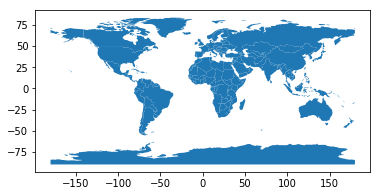

In [11]:
world.plot();

# Time series

In [36]:
# source for plotting bars

# subset by country
country_key = 'United Kingdom'
merged_subset = merged.loc[merged['country'] == country_key].copy()

# convert day strings to datetimes for plotting as time series
merged_subset['day'] = pd.to_datetime(merged_subset['day'])
merged_subset.drop('geometry', axis=1, inplace=True)
merged_subset.head()

,country,day,confirmed,deaths,recovered,country_original
10025,United Kingdom,2020-01-22,0.0,0.0,0.0,United Kingdom
10026,United Kingdom,2020-01-23,0.0,0.0,0.0,United Kingdom
10027,United Kingdom,2020-01-24,0.0,0.0,0.0,United Kingdom
10028,United Kingdom,2020-01-25,0.0,0.0,0.0,United Kingdom
10029,United Kingdom,2020-01-26,0.0,0.0,0.0,United Kingdom


In [38]:
#source = ColumnDataSource(merged_subset) # coldatasources must exclude geometry column
df = merged_subset

metric = 'confirmed'

p = figure(title='Country', plot_height=400 , plot_width=850, 
           toolbar_location='right', 
           tools='wheel_zoom, pan, reset', 
           x_axis_label='Date', y_axis_label='Count',
        x_axis_type='datetime')

# p.xgrid.grid_line_color = None
# p.ygrid.grid_line_color = None

p.line(df['day'], df[metric])

# format the date on x axis
p.xaxis.formatter = DatetimeTickFormatter(days=["%d %b"])
    
# add thousand-separator to y axis
p.yaxis.formatter=NumeralTickFormatter() 


# Create a HoverTool: hover
hover = HoverTool(tooltips=TOOLTIPS)

# Add the hover tool to the figure p
p.add_tools(hover)


output_notebook()
show(p)

Loading BokehJS ...

# Map by province

In [51]:
# # source for mapping by province #TODO - need to unaggregate by province

#merged_subset = merged.loc[merged['country'] == 'United Kingdom']

# source = merged_subset.copy()
# source = GeoJSONDataSource(geojson=json.dumps(json.loads(source.to_json()))) 

# Colorcet palettes are larger and work with Bokeh 
(but colours are lairy...)

In [2]:
import colorcet 

In [ ]:
# view example palettes

# import holoviews as hv
# from colorcet.plotting import swatches, sine_combs
# hv.notebook_extension("bokeh")
# swatches(group="linear")

In [8]:
# access a named palette using colourcet.name, e.g.:
# need b_ prefix to format as list that is accepted by Bokeh

colorcet.b_linear_blue_5_95_c73 # confirmed
colorcet.b_linear_green_5_95_c69 # recovered
colorcet.b_linear_kry_5_95_c72 # deaths

['#f6f909',
 '#f6f70d',
 '#f6f610',
 '#f5f513',
 '#f5f415',
 '#f4f218',
 '#f4f11a',
 '#f3f01b',
 '#f3ef1d',
 '#f3ed1f',
 '#f2ec20',
 '#f2eb21',
 '#f2ea23',
 '#f1e824',
 '#f1e725',
 '#f1e626',
 '#f0e527',
 '#f0e328',
 '#f0e228',
 '#f0e129',
 '#f0df2a',
 '#efde2a',
 '#efdd2b',
 '#efdb2b',
 '#efda2c',
 '#efd92c',
 '#efd72c',
 '#efd62d',
 '#efd52d',
 '#efd32d',
 '#efd22d',
 '#efd02d',
 '#efcf2d',
 '#efce2d',
 '#efcc2d',
 '#efcb2d',
 '#f0c92d',
 '#f0c82c',
 '#f0c62c',
 '#f1c52b',
 '#f1c32b',
 '#f1c12a',
 '#f2c029',
 '#f3be28',
 '#f3bd27',
 '#f4bb26',
 '#f4b925',
 '#f5b824',
 '#f5b623',
 '#f6b422',
 '#f6b322',
 '#f7b121',
 '#f7af20',
 '#f8ae1f',
 '#f8ac1e',
 '#f8aa1e',
 '#f9a81d',
 '#f9a71c',
 '#faa51b',
 '#faa31b',
 '#faa21a',
 '#faa019',
 '#fb9e19',
 '#fb9d18',
 '#fb9b18',
 '#fb9917',
 '#fc9717',
 '#fc9616',
 '#fc9416',
 '#fc9215',
 '#fc9015',
 '#fd8f15',
 '#fd8d14',
 '#fd8b14',
 '#fd8914',
 '#fd8813',
 '#fd8613',
 '#fd8413',
 '#fd8212',
 '#fe8012',
 '#fe7e12',
 '#fe7d11',
 '#fe7b11',
 '#f